## 1. Preparation

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 1.1. Import data

In [ ]:
df = pd.read_csv('Data/Data_10xsum3y.csv')
df

,Date,Temp,Turb,EC,pH,Colour,Bicarbonate,Silica,TKN,Sol_react_P,Flow,Cyano
0,1985/6/1,13.0,32,512,7.8,12,204.00,16.7,0.68,0.26,230,32018.4
1,1985/6/2,13.0,32,512,7.8,12,204.00,16.7,0.68,0.26,234,19029.6
2,1985/6/3,13.0,32,512,7.8,12,204.00,16.7,0.68,0.26,238,6048.0
3,1985/6/4,12.0,30,525,7.8,11,204.00,14.1,0.76,0.21,246,5292.0
4,1985/6/5,12.0,30,525,7.8,11,204.00,14.1,0.76,0.21,246,4536.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1076,1988/5/27,13.0,320,435,7.6,238,142.80,26.6,1.46,0.19,797,0.0
1077,1988/5/28,13.0,320,435,7.6,238,142.80,26.6,1.46,0.19,824,0.0
1078,1988/5/29,13.0,320,435,7.6,238,142.80,26.6,1.46,0.19,816,0.0
1079,1988/5/30,13.0,320,435,7.6,238,142.80,26.6,1.46,0.19,812,0.0


In [5]:
data = df.iloc[:, 1:]
data = data.astype('float32')
data

,Temp,Turb,EC,pH,Colour,Bicarbonate,Silica,TKN,Sol_react_P,Flow,Cyano
0,13.0,32.0,512.0,7.8,12.0,204.000000,16.700001,0.68,0.26,230.0,32018.400391
1,13.0,32.0,512.0,7.8,12.0,204.000000,16.700001,0.68,0.26,234.0,19029.599609
2,13.0,32.0,512.0,7.8,12.0,204.000000,16.700001,0.68,0.26,238.0,6048.000000
3,12.0,30.0,525.0,7.8,11.0,204.000000,14.100000,0.76,0.21,246.0,5292.000000
4,12.0,30.0,525.0,7.8,11.0,204.000000,14.100000,0.76,0.21,246.0,4536.000000
...,...,...,...,...,...,...,...,...,...,...,...
1076,13.0,320.0,435.0,7.6,238.0,142.800003,26.600000,1.46,0.19,797.0,0.000000
1077,13.0,320.0,435.0,7.6,238.0,142.800003,26.600000,1.46,0.19,824.0,0.000000
1078,13.0,320.0,435.0,7.6,238.0,142.800003,26.600000,1.46,0.19,816.0,0.000000
1079,13.0,320.0,435.0,7.6,238.0,142.800003,26.600000,1.46,0.19,812.0,0.000000


## 2. Construction of data sets

### 2.1. Processing outliers

In [6]:
from scipy.stats import zscore

# Calculate the Z-Score for each column
for col in data.columns:
    data['ZScored'] = zscore(data[col])
    rolling_mean = data[col].rolling(window=5, center=True, min_periods=1).mean()
    data[col] = data.apply(lambda row: rolling_mean[row.name] if abs(row['ZScored']) > 2 else row[col], axis=1)
 
data = data.drop(columns=['ZScored'])
data

,Temp,Turb,EC,pH,Colour,Bicarbonate,Silica,TKN,Sol_react_P,Flow,Cyano
0,13.0,32.000000,512.0,7.80,12.0,204.000000,16.700001,0.68,0.260000,230.0,32018.400391
1,13.0,32.000000,512.0,7.80,12.0,204.000000,16.700001,0.68,0.260000,234.0,19029.599609
2,13.0,32.000000,512.0,7.80,12.0,204.000000,16.700001,0.68,0.260000,238.0,6048.000000
3,12.0,30.000000,525.0,7.80,11.0,204.000000,14.100000,0.76,0.210000,246.0,5292.000000
4,12.0,30.000000,525.0,7.80,11.0,204.000000,14.100000,0.76,0.210000,246.0,4536.000000
...,...,...,...,...,...,...,...,...,...,...,...
1076,13.0,320.000000,435.0,7.60,238.0,142.800003,26.600000,1.46,0.190000,797.0,0.000000
1077,13.0,320.000000,435.0,7.60,238.0,142.800003,26.600000,1.46,0.190000,824.0,0.000000
1078,13.0,285.000000,435.0,7.64,202.0,142.800003,26.540000,1.46,0.190000,816.0,0.000000
1079,13.0,276.250000,435.0,7.65,193.0,142.800003,26.525000,1.46,0.190000,812.0,0.000000


### 2.2. Set features and targets

In [7]:
feature_size = 10
target_size = 1

features = data[data.columns[:feature_size]].values.copy()
targets = data['Cyano'].values.copy()

features.shape, targets.shape

((1081, 10), (1081,))

### 2.3. Split data set

In [ ]:
win_size = 30 # Sliding window size
pre_times = 1 # Time step of prediction

dataX = []
dataY = []
for index in range(len(data) - win_size - pre_times): 
    window_X = features[index: index + win_size, :]        
    target_Y = targets[index + win_size:index + win_size + pre_times]
    dataX.append(window_X)
    dataY.append(target_Y)

dataX = np.array(dataX)
dataY = np.array(dataY)

dataX.shape, dataY.shape

((1050, 30, 10), (1050, 1))

In [ ]:
train_size = int(np.round(0.8 * dataX.shape[0]))
x_train = dataX[: train_size, :]
y_train = dataY[: train_size, :]
x_test = dataX[train_size:, :]
y_test = dataY[train_size:, :]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((840, 30, 10), (840, 1), (210, 30, 10), (210, 1))

### 2.4. Normalize the data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

x_train = MinMaxScaler().fit_transform(x_train.reshape(-1,features.shape[1]))
y_train = MinMaxScaler().fit_transform(y_train)
x_test = MinMaxScaler().fit_transform(x_test.reshape(-1,features.shape[1]))
y_test = MinMaxScaler().fit_transform(y_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((25200, 10), (840, 1), (6300, 10), (210, 1))

In [ ]:
x_train_tensor = torch.tensor(x_train.reshape(-1,win_size,features.shape[1]), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.reshape(-1,pre_times,target_size), dtype=torch.float32).to(device)
x_test_tensor = torch.tensor(x_test.reshape(-1,win_size,features.shape[1]), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.reshape(-1,pre_times,target_size), dtype=torch.float32).to(device)

x_train_tensor.shape, y_train_tensor.shape, x_test_tensor.shape, y_test_tensor.shape

(torch.Size([840, 30, 10]),
 torch.Size([840, 1, 1]),
 torch.Size([210, 30, 10]),
 torch.Size([210, 1, 1]))

## 3. Model training

### 3.1. Constructing the model

#### RNN

In [ ]:
class model_rnn(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, pre_times, dropout):
        super(model_rnn, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, pre_times)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
model = model_rnn(input_size=feature_size, hidden_size=32, num_layers=2, 
                  pre_times=pre_times, dropout=0.4).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.003, weight_decay=1e-6)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)


### 3.2. Training model

In [ ]:
import time
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset

num_epochs = 500
train_loss_list = []
val_loss_list = []
early_stopping_patience = 10

# Define KFold
k_folds = 10
kf = KFold(n_splits=k_folds, shuffle=True)
KFold_epochs = []

start_time = time.time()
for fold, (train_indices, val_indices) in enumerate(kf.split(x_train_tensor, y_train_tensor)):
    print(f'Fold {fold+1}/{k_folds}')
    train_loader = DataLoader(TensorDataset(x_train_tensor[train_indices], y_train_tensor[train_indices]), batch_size=512, shuffle=True)
    val_loader = DataLoader(TensorDataset(x_train_tensor[val_indices], y_train_tensor[val_indices]), batch_size=512, shuffle=True)
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(num_epochs):
        model.train()
        training_loss = 0
        for data in train_loader:
            x_train, y_train = data   
            optimizer.zero_grad() 
            y_train_pred = model(x_train)
            loss_training = loss_fn(y_train_pred.reshape(-1, target_size), y_train.reshape(-1, target_size))
            loss_training.backward() 
            optimizer.step() 
            training_loss += loss_training.item()
        train_loss_list.append(training_loss / len(train_loader))
        if lr_scheduler is not None:
            lr_scheduler.step()

        model.eval()
        valing_loss = 0
        val_losses = [] 
        with torch.no_grad():
            for data in val_loader:
                x_val, y_val = data
                y_val_pred = model(x_val)
                loss_valing = loss_fn(y_val_pred.reshape(-1, target_size), y_val.reshape(-1, target_size))
                valing_loss += loss_valing.item()
                val_losses.append(loss_valing.item())
        val_loss_list.append(valing_loss / len(val_loader))
        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Learning Rate: {lr_scheduler.get_last_lr()}, Training Loss: {training_loss / len(train_loader):.4f}, Valing Loss: {valing_loss / len(val_loader):.4f}")
        elif (epoch+1) == 1:  
            print(f"Epoch [{epoch+1}/{num_epochs}], Learning Rate: {lr_scheduler.get_last_lr()}, Training Loss: {training_loss / len(train_loader):.4f}, Valing Loss: {valing_loss / len(val_loader):.4f}")
        valing_loss = valing_loss / len(val_loader)
        if valing_loss < best_val_loss:
            best_val_loss = valing_loss
            torch.save(model.state_dict(), 'RNN.pth')
            patience_counter = 0 
        else:
            patience_counter += 1 
        if patience_counter >= early_stopping_patience:
            print(f'Early stopping at epoch {epoch+1}')
            KFold_epochs.append(epoch+1)
            break
        elif epoch == num_epochs - 1:
            KFold_epochs.append(epoch+1)
end_time = time.time()

print(f"Total epochs: {np.sum(KFold_epochs)}")
time_per_epoch = (end_time-start_time)/(np.sum(KFold_epochs))
print(f"Training time: {end_time-start_time}s")
print(f"Time per epoch: {time_per_epoch}s")
print("="*20, "Training Finished", "="*20)

Fold 1/10
Epoch [1/500], Learning Rate: [0.003], Training Loss: 0.0200, Valing Loss: 0.0153
Epoch [10/500], Learning Rate: [0.0027], Training Loss: 0.0133, Valing Loss: 0.0081
Epoch [20/500], Learning Rate: [0.0024300000000000003], Training Loss: 0.0072, Valing Loss: 0.0056
Epoch [30/500], Learning Rate: [0.002187], Training Loss: 0.0067, Valing Loss: 0.0053
Early stopping at epoch 34
Fold 2/10
Epoch [1/500], Learning Rate: [0.002187], Training Loss: 0.0077, Valing Loss: 0.0042
Epoch [10/500], Learning Rate: [0.0019683], Training Loss: 0.0055, Valing Loss: 0.0045
Epoch [20/500], Learning Rate: [0.00177147], Training Loss: 0.0060, Valing Loss: 0.0040
Early stopping at epoch 23
Fold 3/10
Epoch [1/500], Learning Rate: [0.00177147], Training Loss: 0.0057, Valing Loss: 0.0053
Epoch [10/500], Learning Rate: [0.0015943230000000001], Training Loss: 0.0052, Valing Loss: 0.0056
Early stopping at epoch 18
Fold 4/10
Epoch [1/500], Learning Rate: [0.0014348907], Training Loss: 0.0048, Valing Loss: 

## 4. Model evaluation

### 4.1. Loss graph

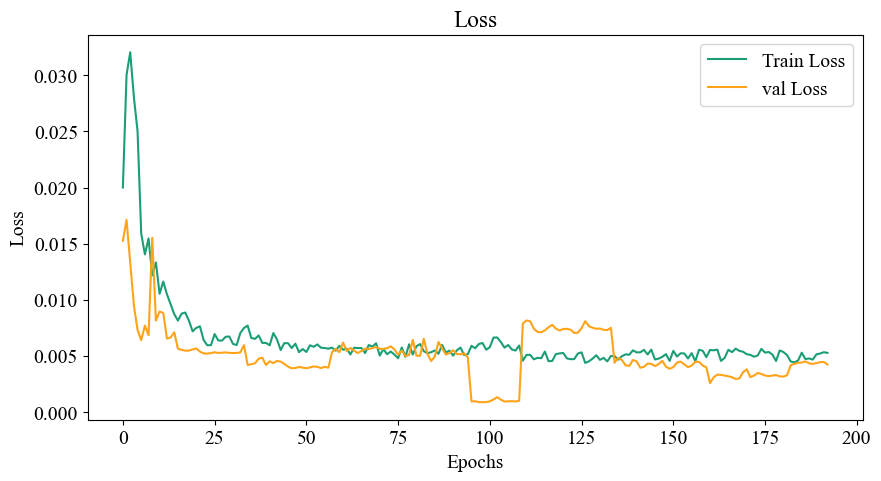

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5), dpi=100)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size': 14})
plt.plot(train_loss_list, label='Train Loss', color='#1b9e77')
plt.plot(val_loss_list, label='val Loss', color='#FFA319')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.show()

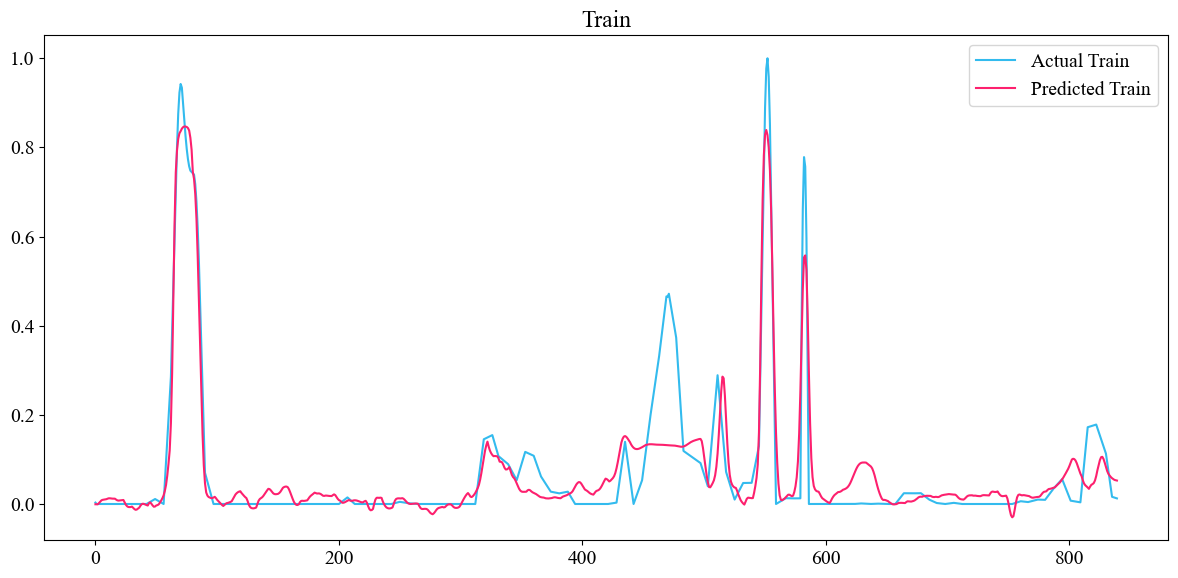

In [ ]:
# Plot the training set results
y_train_pred = model(x_train_tensor)
predicted_train = y_train_pred.cpu().detach().numpy().reshape(-1, target_size)
actual_train = y_train_tensor.cpu().detach().numpy().reshape(-1, target_size)

plt.figure(figsize=(12, 6))
plt.plot(actual_train[:1000], label=f'Actual Train', color='#33BBEE')
plt.plot(predicted_train[:1000], label=f'Predicted Train', color='#fd206e')
plt.legend()
plt.title(f'Train')
plt.tight_layout()
plt.show()

### 4.2. Use the model to predict

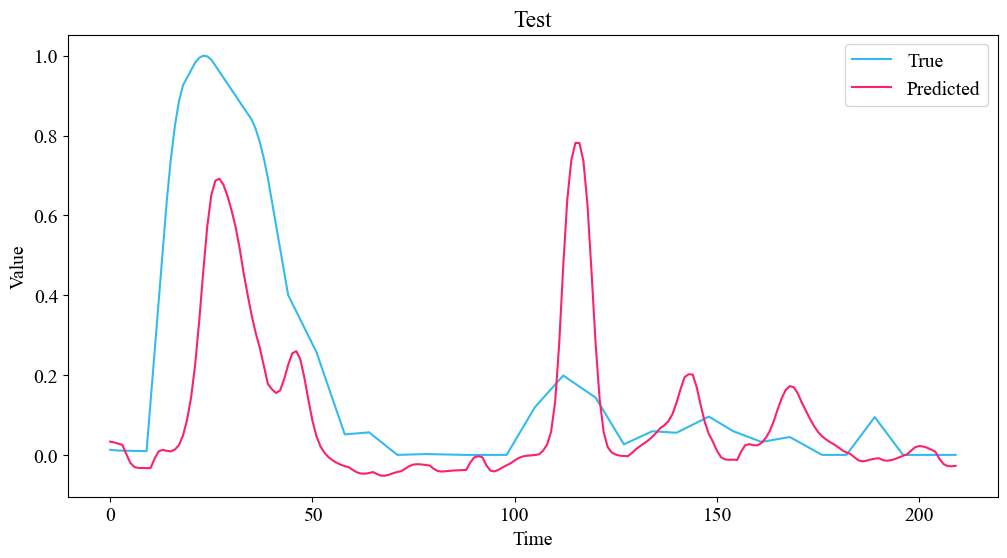

In [86]:
y_test_pred = model(x_test_tensor)

predicted_test = y_test_pred.cpu().detach().numpy().reshape(-1, target_size)
actual_test = y_test_tensor.cpu().detach().numpy().reshape(-1, target_size)

# predicted_x = np.arange(300, 300 + len(y_hat)) # 偏移预测值的x轴坐标

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(actual_test[:1000], label='True', color='#33BBEE')
plt.plot(predicted_test[:1000], label='Predicted', color='#fd206e')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Test')
plt.show()

### 4.3. Evaluation index

In [87]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

print("MSE: ", mean_squared_error(actual_test, predicted_test))
print("R2 Score: ", r2_score(actual_test, predicted_test))
print("MAE: ", mean_absolute_error(actual_test, predicted_test))
print("MedAE: ", median_absolute_error(actual_test, predicted_test))

MSE:  0.05917109
R2 Score:  0.28692679324923065
MAE:  0.14540252
MedAE:  0.06952918
